In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

import itertools
import math

%matplotlib inline

# pd.set_option("display.max_rows", 10)

np.random.seed(2)

In [51]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.wrappers.scikit_learn import KerasRegressor


In [52]:
# Load the data
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [53]:
train.columns


Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [54]:
train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
                  ...   
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object
GarageYrBlt      float64


In [55]:
# fill missing text fields with a default string
object_columns = train.select_dtypes(include=[object])

cols_with_none_as_nan = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', "MasVnrType"]
for col in cols_with_none_as_nan:
    object_columns[col].fillna('None', inplace=True)

object_columns.fillna('NoData', inplace=True)

test_object_columns = test.select_dtypes(include=[object])
test_object_columns.fillna('NoData', inplace=True)


/home/daneel/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/daneel/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [56]:
int_columns = train.select_dtypes(include=[int, float])
test_int_columns = test.select_dtypes(include=[int, float])

int_columns.isnull().sum()

Id                 0
MSSubClass         0
LotFrontage      259
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         8
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       81
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
SalePrice          0
dtype: int64

In [57]:
int_columns['LotFrontage'].fillna(int_columns['LotFrontage'].mean(), inplace=True)
int_columns['MasVnrArea'].fillna(0, inplace=True)
int_columns['GarageYrBlt'].fillna(0, inplace=True)

test_int_columns['LotFrontage'].fillna(test_int_columns['LotFrontage'].mean(), inplace=True)
test_int_columns['GarageYrBlt'].fillna(0, inplace=True)
test_int_columns['MasVnrArea'].fillna(0, inplace=True)
test_int_columns['BsmtFinSF1'].fillna(0, inplace=True)
test_int_columns['BsmtFinSF2'].fillna(0, inplace=True)
test_int_columns['BsmtUnfSF'].fillna(0, inplace=True)
test_int_columns['TotalBsmtSF'].fillna(0, inplace=True)
test_int_columns['BsmtFullBath'].fillna(0, inplace=True)
test_int_columns['BsmtHalfBath'].fillna(0, inplace=True)
test_int_columns['GarageCars'].fillna(0, inplace=True)
test_int_columns['GarageArea'].fillna(0, inplace=True)

int_columns.isnull().sum()
test_int_columns.isnull().sum()

/home/daneel/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Id               0
MSSubClass       0
LotFrontage      0
LotArea          0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageYrBlt      0
GarageCars       0
GarageArea       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
dtype: int64

In [58]:
train['SalePrice'].describe()


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

/home/daneel/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/daneel/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/daneel/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`

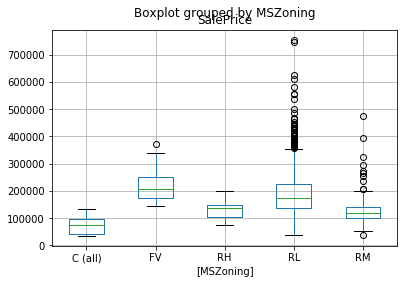

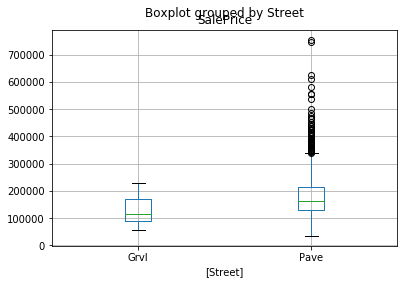

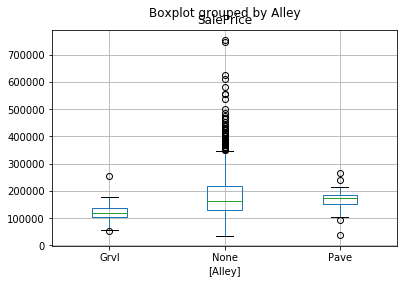

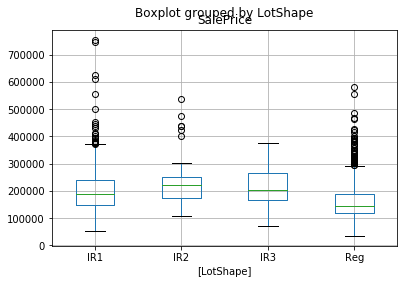

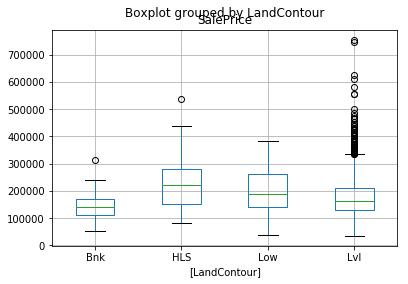

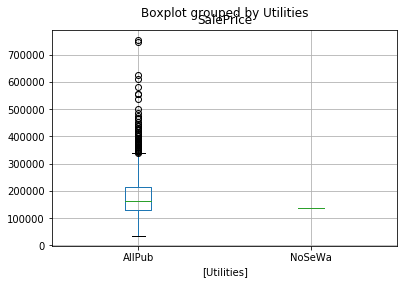

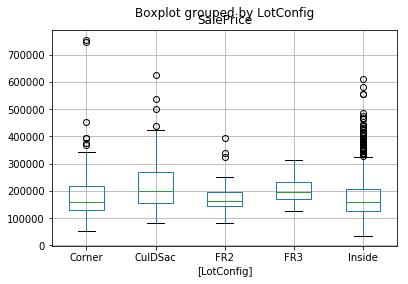

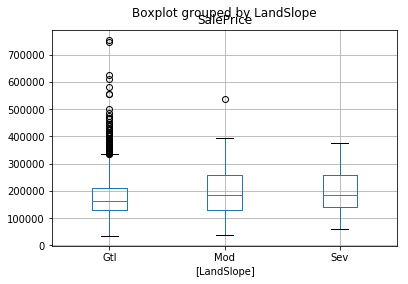

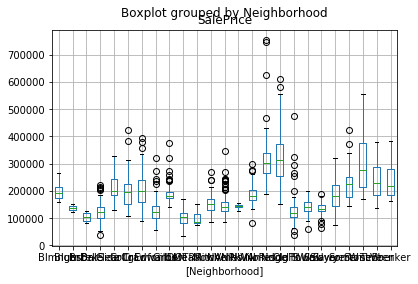

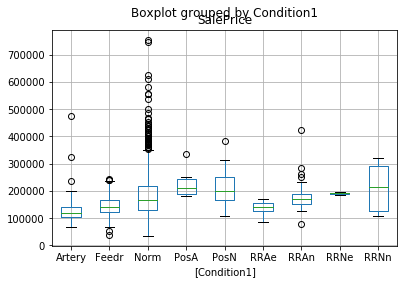

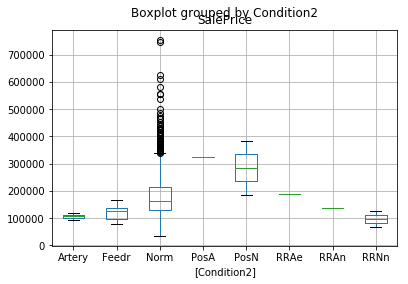

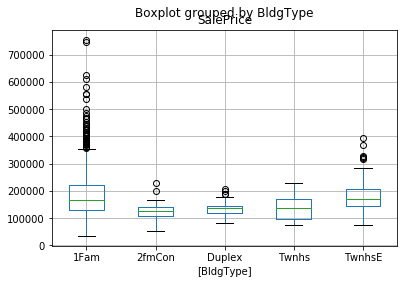

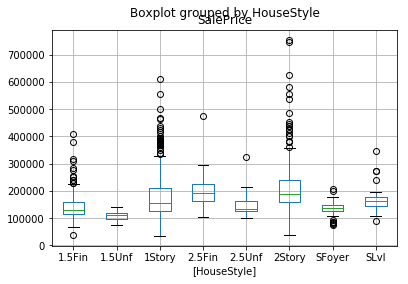

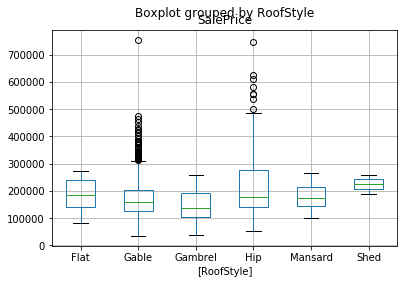

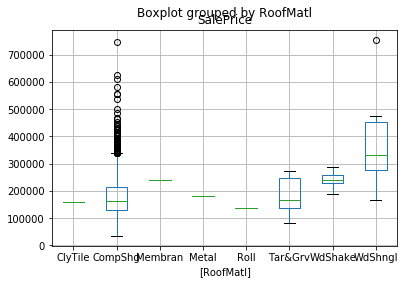

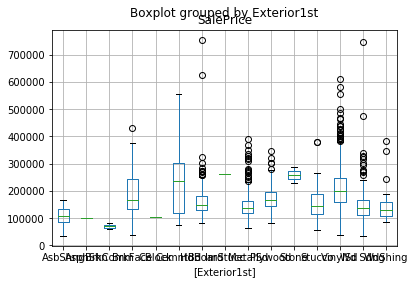

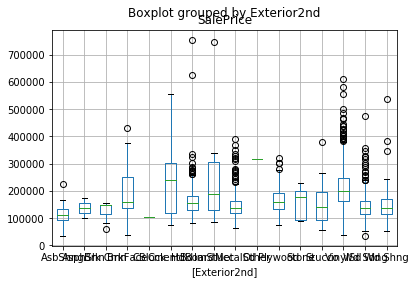

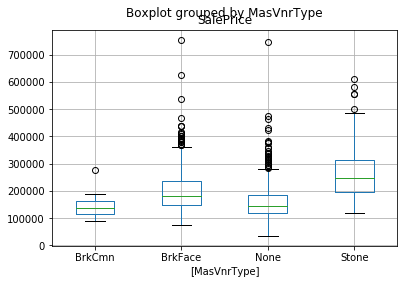

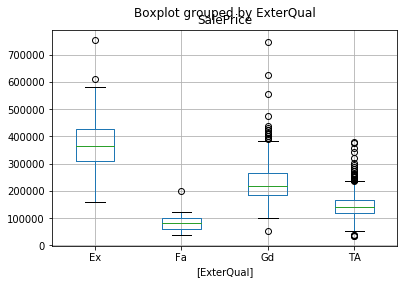

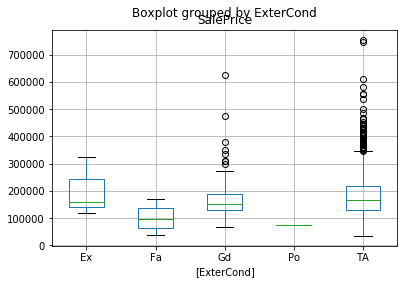

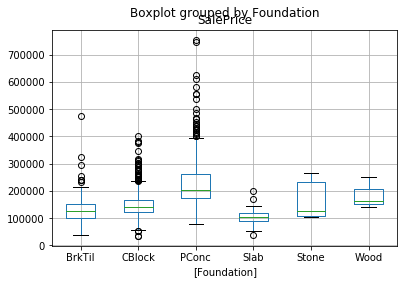

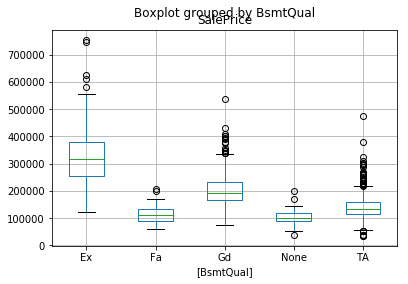

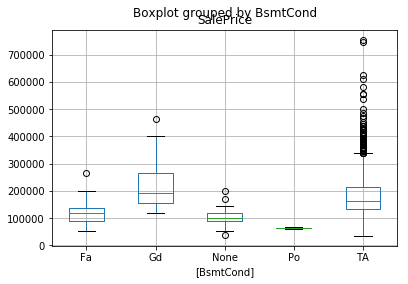

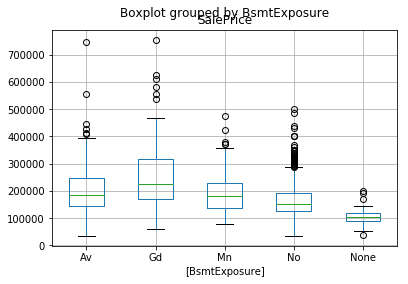

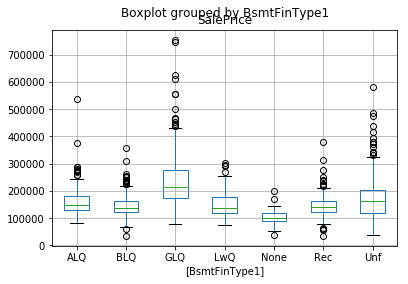

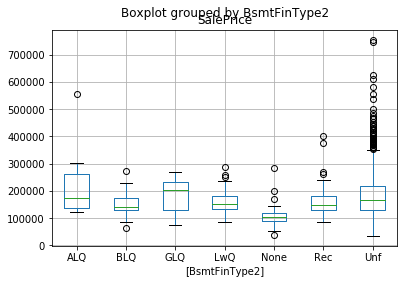

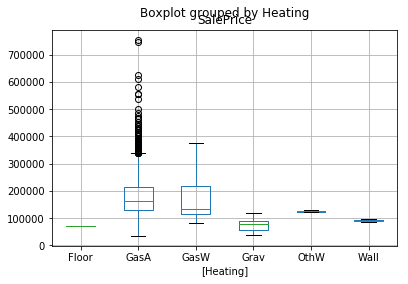

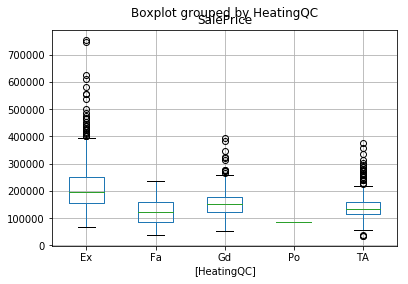

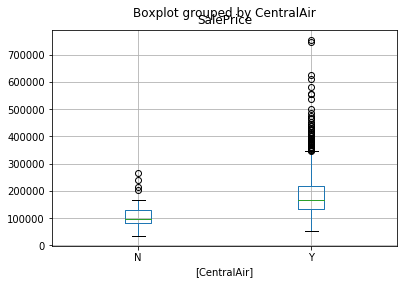

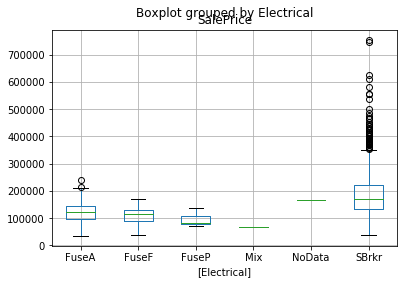

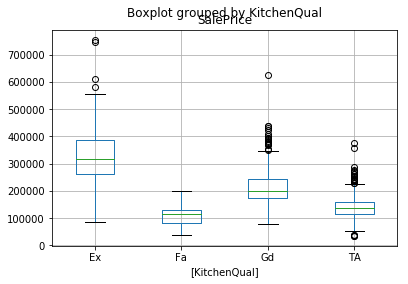

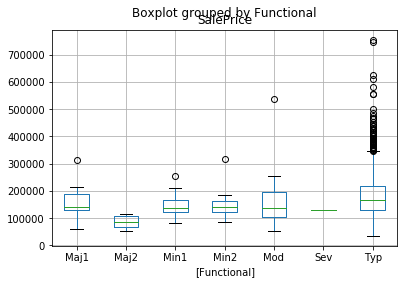

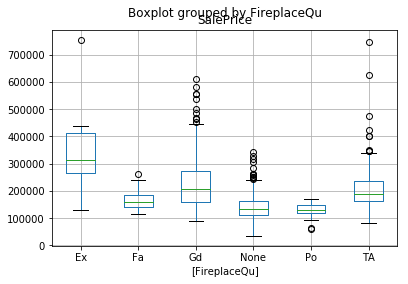

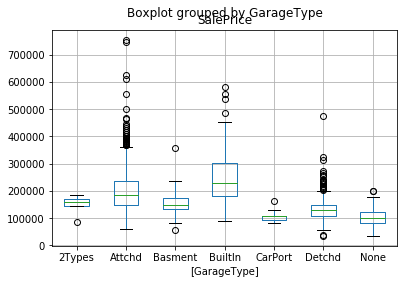

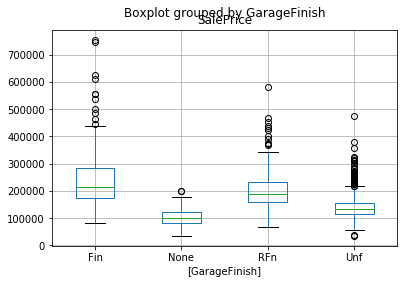

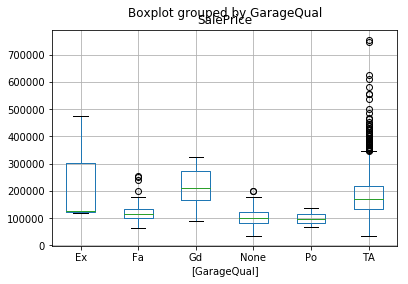

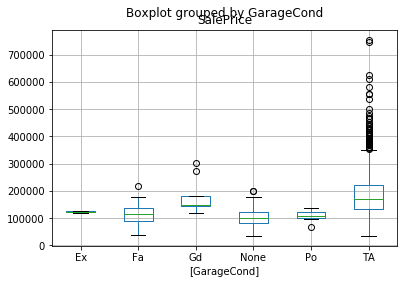

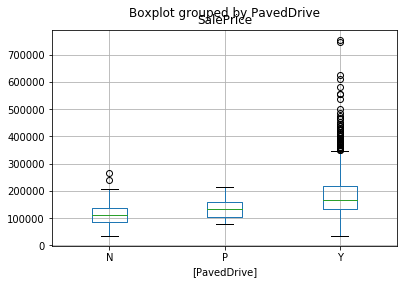

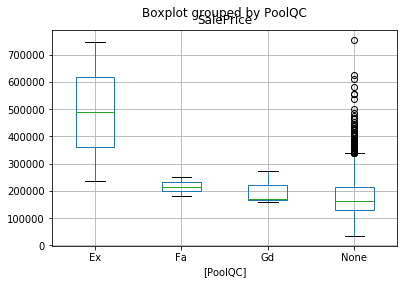

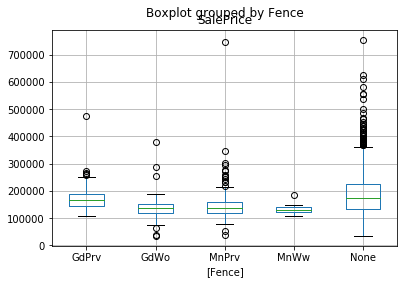

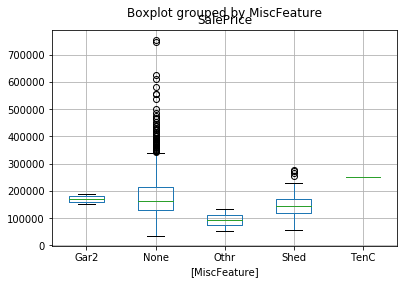

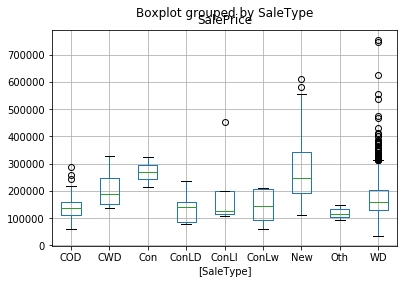

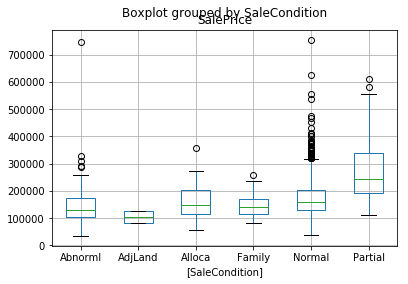

In [59]:
object_columns.loc[:,'SalePrice'] = train.loc[:,'SalePrice']
for c in object_columns.columns:
    if c != 'SalePrice':
        object_columns.boxplot(column=['SalePrice'], by=[c])

object_columns.drop('SalePrice', axis=1, inplace=True)



/home/daneel/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/daneel/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


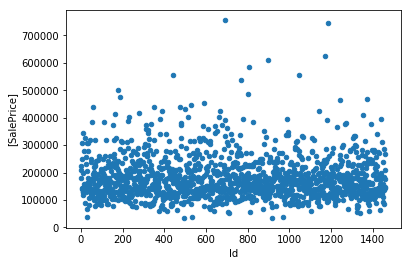

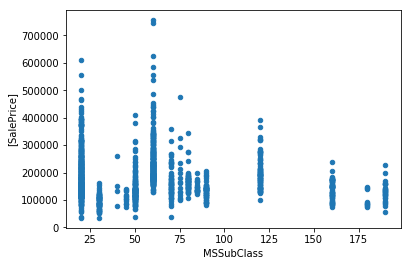

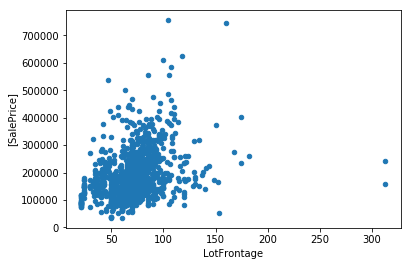

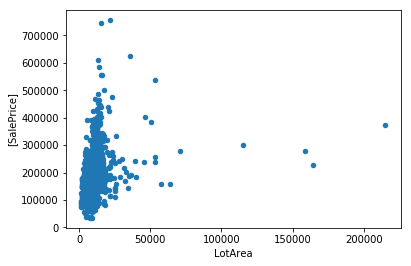

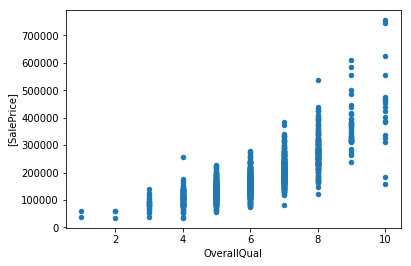

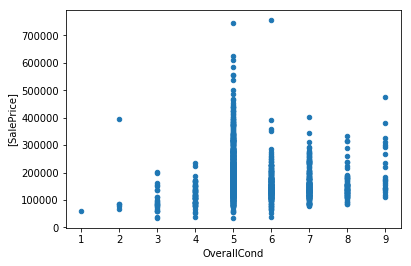

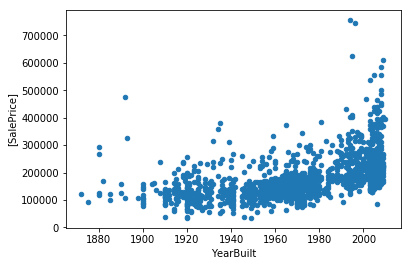

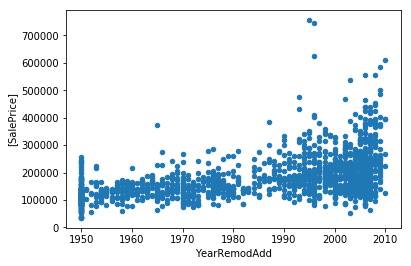

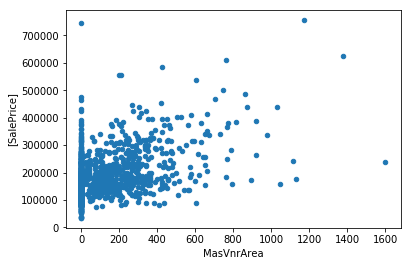

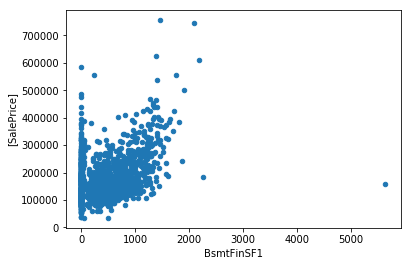

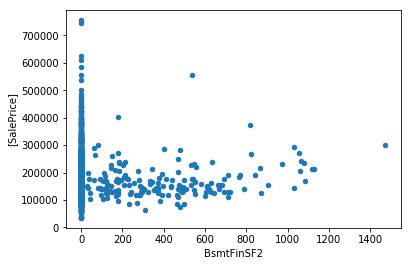

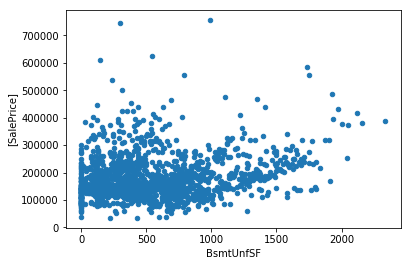

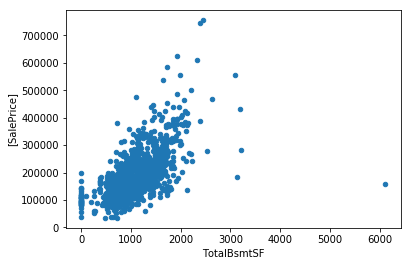

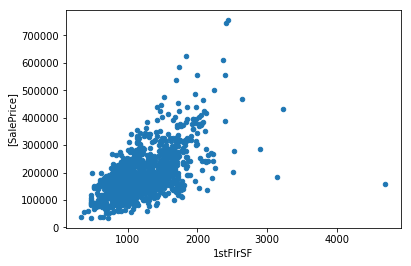

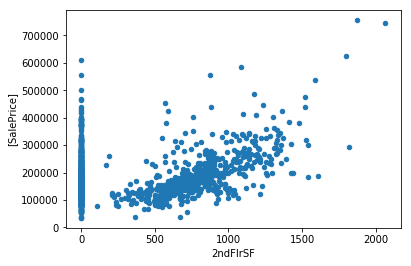

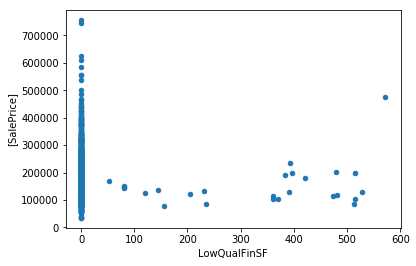

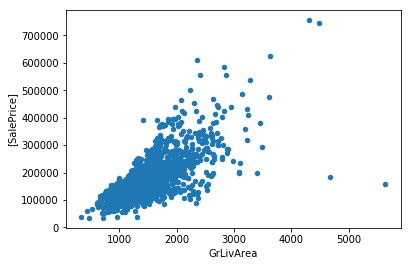

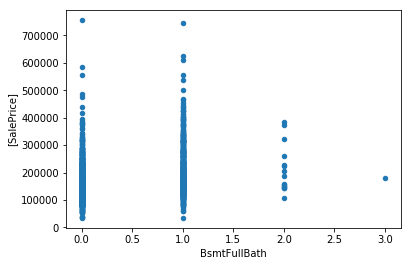

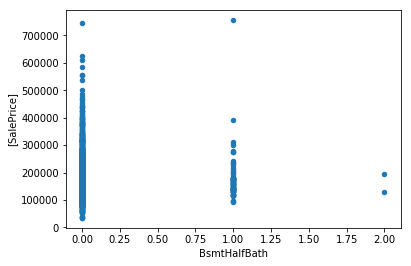

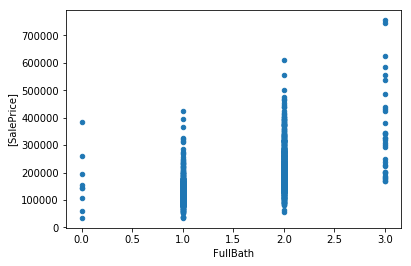

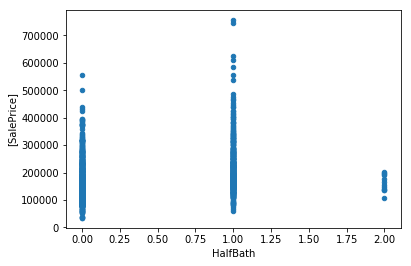

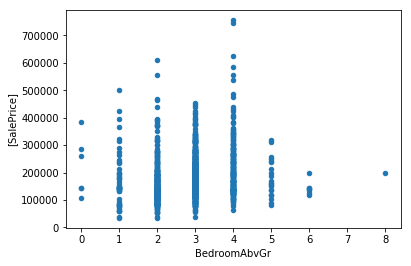

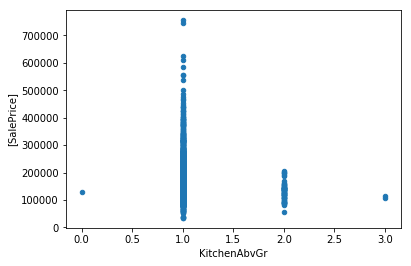

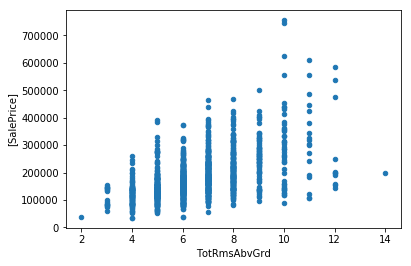

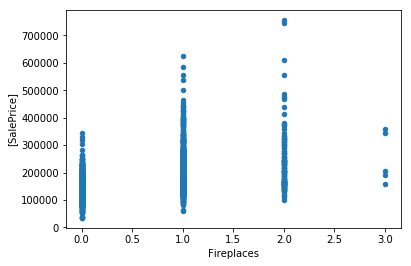

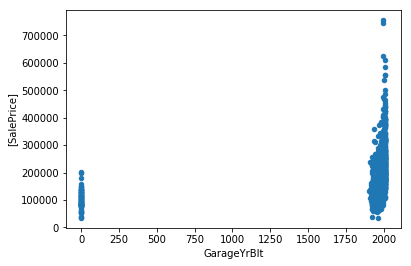

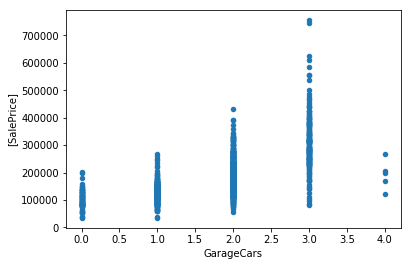

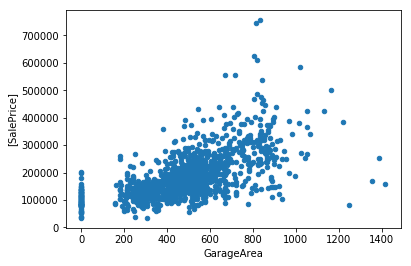

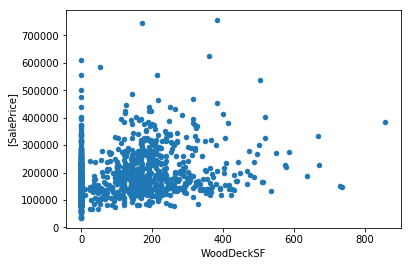

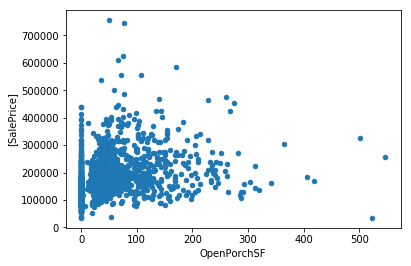

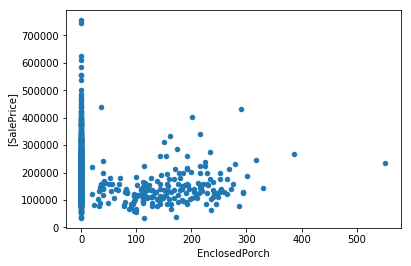

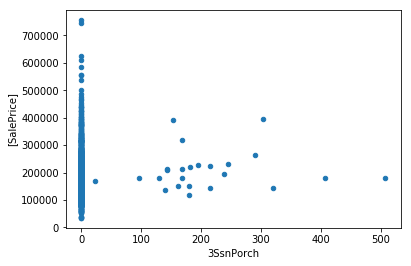

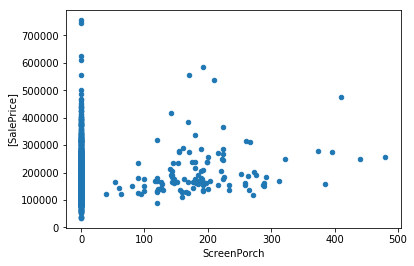

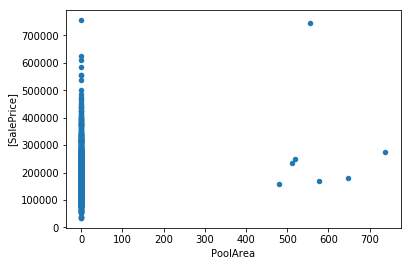

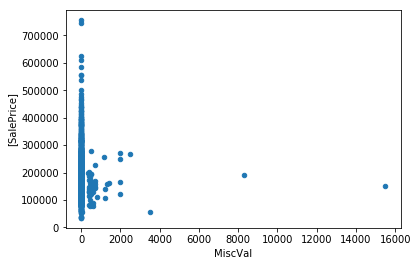

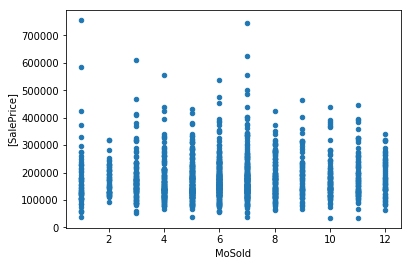

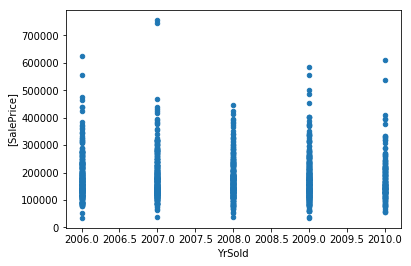

In [60]:

int_columns.loc[:,'SalePrice'] = train.loc[:,'SalePrice']
for c in int_columns.columns:
    if c != 'SalePrice':
        int_columns.plot.scatter(y=['SalePrice'], x=c)


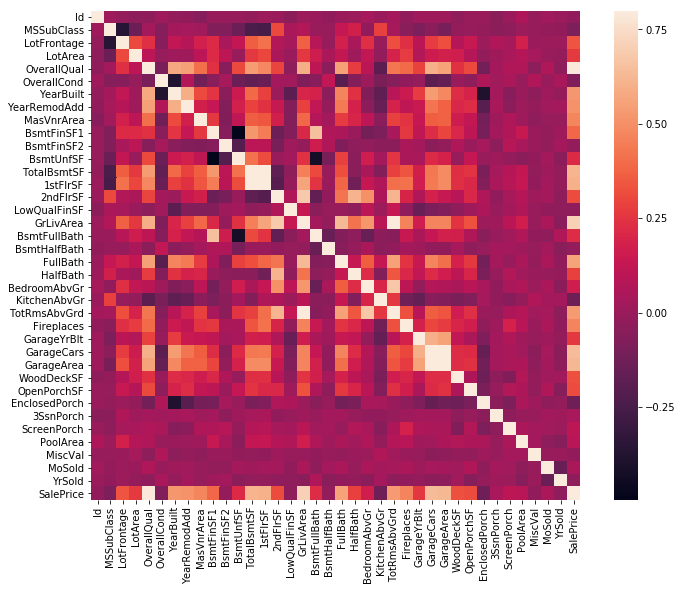

In [61]:
#correlation matrix
corrmat = int_columns.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);



In [62]:

strings = np.array([])
for c in object_columns.columns:
    strings = np.append(strings, pd.unique(object_columns[c].values))

for c in test_object_columns.columns:
    strings = np.append(strings, pd.unique(test_object_columns[c].values))

print(len(strings))

labeler = LabelEncoder()
labeler.fit(strings)

for c in object_columns.columns:
    object_columns.loc[:,c] = labeler.transform(object_columns.loc[:,c])
    test_object_columns.loc[:,c] = labeler.transform(test_object_columns.loc[:,c])

object_columns[0:5]

523


/home/daneel/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/home/daneel/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,134,127,115,141,89,12,87,78,41,116,...,17,132,156,156,174,115,115,115,166,117
1,134,127,115,141,89,12,54,78,164,59,...,17,132,156,156,174,115,115,115,166,117
2,134,127,115,83,89,12,87,78,41,116,...,17,132,156,156,174,115,115,115,166,117
3,134,127,115,83,89,12,47,78,48,116,...,50,163,156,156,174,115,115,115,166,10
4,134,127,115,83,89,12,54,78,113,116,...,17,132,156,156,174,115,115,115,166,117


In [63]:
# final dataset
train_ds = object_columns.join(int_columns)
test_ds = test_object_columns.join(test_int_columns)

train_ds.describe()


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,129.967123,126.794521,114.035616,119.788356,85.784932,12.069863,76.197945,79.834247,96.564384,110.389726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,18.062196,3.199807,7.252716,27.901737,13.461097,2.669462,17.394661,8.603914,41.154942,22.550366,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,32.000000,77.000000,77.000000,83.000000,23.000000,12.000000,47.000000,78.000000,21.000000,14.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,134.000000,127.000000,115.000000,83.000000,89.000000,12.000000,54.000000,78.000000,52.000000,116.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,134.000000,127.000000,115.000000,141.000000,89.000000,12.000000,87.000000,78.000000,107.000000,116.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,134.000000,127.000000,115.000000,141.000000,89.000000,12.000000,87.000000,78.000000,119.000000,116.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,135.000000,127.000000,127.000000,141.000000,89.000000,114.000000,87.000000,149.000000,164.000000,139.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [64]:
X_train = (train_ds.values[:,:-1])
y_train = np.asarray([[t] for t in (train_ds.values[:,-1])])
X_test = test_ds.values

print(X_train.shape)
print(y_train.shape)
print(test_ds.shape)

print(X_test[0:2])

(1460, 80)
(1460, 1)
(1459, 80)
[[1.3300e+02 1.2700e+02 1.1200e+02 1.4100e+02 8.9000e+01 1.2000e+01
  8.7000e+01 7.8000e+01 1.0700e+02 5.9000e+01 1.1600e+02 2.0000e+00
  3.0000e+00 6.7000e+01 4.2000e+01 1.6500e+02 1.6500e+02 1.1500e+02
  1.5600e+02 1.5600e+02 3.3000e+01 1.5600e+02 1.5600e+02 1.1100e+02
  1.4000e+02 9.0000e+01 7.0000e+01 1.5600e+02 1.7400e+02 1.4300e+02
  1.5600e+02 1.6200e+02 1.1200e+02 1.7000e+01 1.6300e+02 1.5600e+02
  1.5600e+02 1.7400e+02 1.1200e+02 1.0300e+02 1.1200e+02 1.6600e+02
  1.1700e+02 1.4610e+03 2.0000e+01 8.0000e+01 1.1622e+04 5.0000e+00
  6.0000e+00 1.9610e+03 1.9610e+03 0.0000e+00 4.6800e+02 1.4400e+02
  2.7000e+02 8.8200e+02 8.9600e+02 0.0000e+00 0.0000e+00 8.9600e+02
  0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 2.0000e+00 1.0000e+00
  5.0000e+00 0.0000e+00 1.9610e+03 1.0000e+00 7.3000e+02 1.4000e+02
  0.0000e+00 0.0000e+00 0.0000e+00 1.2000e+02 0.0000e+00 0.0000e+00
  6.0000e+00 2.0100e+03]
 [1.3400e+02 1.2700e+02 1.1200e+02 8.3000e+01 8.9000e+01 1.

In [65]:
X_tr, X_ts, y_tr, y_ts = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [66]:
def train(dtrain, dtest, depth, rounds):
    # Train xgboost
    param = {'max_depth' : depth, 'silent': 1, 'eta' : 0.5, 'objective' : 'reg:linear', 'seed' : 42}
    num_round = rounds
    bst = xgb.train(param, dtrain, num_round, [(dtest, 'test'), (dtrain, 'train')])
    return bst

def error_check(bst):
    # make prediction
    train_pred = bst.predict(dtrain)
    rmse_train = math.sqrt(mean_squared_error(y_tr[:], train_pred))
    test_pred = bst.predict(dtest)
    rmse_test = math.sqrt(mean_squared_error(y_ts[:], test_pred))
    return rmse_train, rmse_test

result = []
for depth in range(3, 10):
    for rounds in range(10, 100, 5):
        dtrain = xgb.DMatrix(X_tr, y_tr)
        dtest = xgb.DMatrix(X_ts, y_ts)
        bst = train(dtrain, dtest, depth, rounds)
        rmse_train, rmse_test = error_check(bst)
        result.append([depth, rounds, rmse_train, rmse_test])



[0]	test-rmse:109367	train-rmse:105807
[1]	test-rmse:66613	train-rmse:61634.2
[2]	test-rmse:46294.9	train-rmse:40839.7
[3]	test-rmse:37435.3	train-rmse:31546.2
[4]	test-rmse:33695.9	train-rmse:27303.2
[5]	test-rmse:32258.7	train-rmse:25228.2
[6]	test-rmse:30288.1	train-rmse:23661.3
[7]	test-rmse:29941.5	train-rmse:22468.2
[8]	test-rmse:29616	train-rmse:21715.8
[9]	test-rmse:30158.3	train-rmse:20928.6
[0]	test-rmse:109367	train-rmse:105807
[1]	test-rmse:66613	train-rmse:61634.2
[2]	test-rmse:46294.9	train-rmse:40839.7
[3]	test-rmse:37435.3	train-rmse:31546.2
[4]	test-rmse:33695.9	train-rmse:27303.2
[5]	test-rmse:32258.7	train-rmse:25228.2
[6]	test-rmse:30288.1	train-rmse:23661.3
[7]	test-rmse:29941.5	train-rmse:22468.2
[8]	test-rmse:29616	train-rmse:21715.8
[9]	test-rmse:30158.3	train-rmse:20928.6
[10]	test-rmse:29994.3	train-rmse:20205.3
[11]	test-rmse:29845.8	train-rmse:19746.1
[12]	test-rmse:29423.1	train-rmse:18919
[13]	test-rmse:29285.2	train-rmse:18510.9
[14]	test-rmse:29475.5	tra

[25]	test-rmse:28916.5	train-rmse:14777.1
[26]	test-rmse:28874.7	train-rmse:14509.9
[27]	test-rmse:29217.6	train-rmse:14239.1
[28]	test-rmse:29504.4	train-rmse:14009.4
[29]	test-rmse:29516	train-rmse:13773.1
[30]	test-rmse:29434.7	train-rmse:13628.9
[31]	test-rmse:29399.9	train-rmse:13499.7
[32]	test-rmse:29360	train-rmse:13262.9
[33]	test-rmse:29613.1	train-rmse:13071.9
[34]	test-rmse:29622.1	train-rmse:12834.4
[35]	test-rmse:29523.7	train-rmse:12664.8
[36]	test-rmse:29451.8	train-rmse:12482.6
[37]	test-rmse:29329.8	train-rmse:12351.1
[38]	test-rmse:29365.3	train-rmse:12199.1
[39]	test-rmse:29375.3	train-rmse:12100.2
[40]	test-rmse:29510.4	train-rmse:11881.3
[41]	test-rmse:29325.6	train-rmse:11703.8
[42]	test-rmse:29345.5	train-rmse:11618.4
[43]	test-rmse:29310.4	train-rmse:11509.6
[44]	test-rmse:29371.5	train-rmse:11318.4
[0]	test-rmse:109367	train-rmse:105807
[1]	test-rmse:66613	train-rmse:61634.2
[2]	test-rmse:46294.9	train-rmse:40839.7
[3]	test-rmse:37435.3	train-rmse:31546.2
[4]	

[13]	test-rmse:29285.2	train-rmse:18510.9
[14]	test-rmse:29475.5	train-rmse:18152.1
[15]	test-rmse:29338.8	train-rmse:17803.7
[16]	test-rmse:29052.2	train-rmse:17413
[17]	test-rmse:29197.3	train-rmse:17015
[18]	test-rmse:29427.7	train-rmse:16752.3
[19]	test-rmse:29178.3	train-rmse:16444.3
[20]	test-rmse:29253.8	train-rmse:16064.5
[21]	test-rmse:29110	train-rmse:15849.5
[22]	test-rmse:29018.6	train-rmse:15515.4
[23]	test-rmse:29161	train-rmse:15357.5
[24]	test-rmse:29103.9	train-rmse:15045.5
[25]	test-rmse:28916.5	train-rmse:14777.1
[26]	test-rmse:28874.7	train-rmse:14509.9
[27]	test-rmse:29217.6	train-rmse:14239.1
[28]	test-rmse:29504.4	train-rmse:14009.4
[29]	test-rmse:29516	train-rmse:13773.1
[30]	test-rmse:29434.7	train-rmse:13628.9
[31]	test-rmse:29399.9	train-rmse:13499.7
[32]	test-rmse:29360	train-rmse:13262.9
[33]	test-rmse:29613.1	train-rmse:13071.9
[34]	test-rmse:29622.1	train-rmse:12834.4
[35]	test-rmse:29523.7	train-rmse:12664.8
[36]	test-rmse:29451.8	train-rmse:12482.6
[37]

[0]	test-rmse:109367	train-rmse:105807
[1]	test-rmse:66613	train-rmse:61634.2
[2]	test-rmse:46294.9	train-rmse:40839.7
[3]	test-rmse:37435.3	train-rmse:31546.2
[4]	test-rmse:33695.9	train-rmse:27303.2
[5]	test-rmse:32258.7	train-rmse:25228.2
[6]	test-rmse:30288.1	train-rmse:23661.3
[7]	test-rmse:29941.5	train-rmse:22468.2
[8]	test-rmse:29616	train-rmse:21715.8
[9]	test-rmse:30158.3	train-rmse:20928.6
[10]	test-rmse:29994.3	train-rmse:20205.3
[11]	test-rmse:29845.8	train-rmse:19746.1
[12]	test-rmse:29423.1	train-rmse:18919
[13]	test-rmse:29285.2	train-rmse:18510.9
[14]	test-rmse:29475.5	train-rmse:18152.1
[15]	test-rmse:29338.8	train-rmse:17803.7
[16]	test-rmse:29052.2	train-rmse:17413
[17]	test-rmse:29197.3	train-rmse:17015
[18]	test-rmse:29427.7	train-rmse:16752.3
[19]	test-rmse:29178.3	train-rmse:16444.3
[20]	test-rmse:29253.8	train-rmse:16064.5
[21]	test-rmse:29110	train-rmse:15849.5
[22]	test-rmse:29018.6	train-rmse:15515.4
[23]	test-rmse:29161	train-rmse:15357.5
[24]	test-rmse:291

[33]	test-rmse:29613.1	train-rmse:13071.9
[34]	test-rmse:29622.1	train-rmse:12834.4
[35]	test-rmse:29523.7	train-rmse:12664.8
[36]	test-rmse:29451.8	train-rmse:12482.6
[37]	test-rmse:29329.8	train-rmse:12351.1
[38]	test-rmse:29365.3	train-rmse:12199.1
[39]	test-rmse:29375.3	train-rmse:12100.2
[40]	test-rmse:29510.4	train-rmse:11881.3
[41]	test-rmse:29325.6	train-rmse:11703.8
[42]	test-rmse:29345.5	train-rmse:11618.4
[43]	test-rmse:29310.4	train-rmse:11509.6
[44]	test-rmse:29371.5	train-rmse:11318.4
[45]	test-rmse:29465.5	train-rmse:11198.3
[46]	test-rmse:29497.5	train-rmse:11011.7
[47]	test-rmse:29469.6	train-rmse:10826.5
[48]	test-rmse:29516.6	train-rmse:10649.2
[49]	test-rmse:29570.2	train-rmse:10530.1
[50]	test-rmse:29494.7	train-rmse:10382.3
[51]	test-rmse:29530.6	train-rmse:10236.1
[52]	test-rmse:29774.1	train-rmse:10118.4
[53]	test-rmse:29758.8	train-rmse:10038.4
[54]	test-rmse:29748.1	train-rmse:9905.91
[55]	test-rmse:29752.3	train-rmse:9789.75
[56]	test-rmse:29770.5	train-rmse:

[1]	test-rmse:65359.3	train-rmse:59451.3
[2]	test-rmse:44022.7	train-rmse:37259.6
[3]	test-rmse:35763	train-rmse:27348.4
[4]	test-rmse:31962.3	train-rmse:22662.6
[5]	test-rmse:30301.4	train-rmse:20655.2
[6]	test-rmse:29746.1	train-rmse:19367.2
[7]	test-rmse:29168.8	train-rmse:18274.8
[8]	test-rmse:29142.4	train-rmse:17741.5
[9]	test-rmse:29053	train-rmse:16934.2
[10]	test-rmse:28959.7	train-rmse:16290.1
[11]	test-rmse:29536.2	train-rmse:15916
[12]	test-rmse:29997.5	train-rmse:15465.6
[13]	test-rmse:29958.9	train-rmse:14847.6
[14]	test-rmse:29783.8	train-rmse:14219.4
[15]	test-rmse:30151.8	train-rmse:13755.7
[16]	test-rmse:30156.4	train-rmse:13495.4
[17]	test-rmse:30031.2	train-rmse:13290.5
[18]	test-rmse:30216.7	train-rmse:13095
[19]	test-rmse:30059.1	train-rmse:12753
[20]	test-rmse:30038.3	train-rmse:12527.9
[21]	test-rmse:29931.6	train-rmse:12162.2
[22]	test-rmse:30018.3	train-rmse:11813.9
[23]	test-rmse:29990.8	train-rmse:11537.6
[24]	test-rmse:30014.8	train-rmse:11360.7
[0]	test-rm

[25]	test-rmse:30028.1	train-rmse:10955.2
[26]	test-rmse:30071.8	train-rmse:10660.4
[27]	test-rmse:30194.4	train-rmse:10477.7
[28]	test-rmse:30068.6	train-rmse:10381.2
[29]	test-rmse:30060.5	train-rmse:10274.9
[30]	test-rmse:30080.6	train-rmse:10108.3
[31]	test-rmse:30046.3	train-rmse:9827.11
[32]	test-rmse:30035.7	train-rmse:9681.34
[33]	test-rmse:29990.6	train-rmse:9533.57
[34]	test-rmse:29938.9	train-rmse:9285.11
[35]	test-rmse:30007.4	train-rmse:9148.11
[36]	test-rmse:30026	train-rmse:8884.72
[37]	test-rmse:30056.9	train-rmse:8730.8
[38]	test-rmse:30070.8	train-rmse:8517.63
[39]	test-rmse:30109.9	train-rmse:8272.04
[40]	test-rmse:30085.8	train-rmse:8223.77
[41]	test-rmse:30061.4	train-rmse:8022.55
[42]	test-rmse:30085.1	train-rmse:7914.95
[43]	test-rmse:30171.8	train-rmse:7736.24
[44]	test-rmse:30133.8	train-rmse:7531.98
[45]	test-rmse:30084.8	train-rmse:7444.37
[46]	test-rmse:30051	train-rmse:7362.25
[47]	test-rmse:30009.5	train-rmse:7276.89
[48]	test-rmse:30024	train-rmse:7190.98

[58]	test-rmse:29819.7	train-rmse:5796.92
[59]	test-rmse:29835.3	train-rmse:5715.84
[60]	test-rmse:29790.3	train-rmse:5557.81
[61]	test-rmse:29818.2	train-rmse:5443.75
[62]	test-rmse:29827.3	train-rmse:5371.41
[63]	test-rmse:29839	train-rmse:5278.3
[64]	test-rmse:29802.4	train-rmse:5135.83
[0]	test-rmse:109104	train-rmse:105068
[1]	test-rmse:65359.3	train-rmse:59451.3
[2]	test-rmse:44022.7	train-rmse:37259.6
[3]	test-rmse:35763	train-rmse:27348.4
[4]	test-rmse:31962.3	train-rmse:22662.6
[5]	test-rmse:30301.4	train-rmse:20655.2
[6]	test-rmse:29746.1	train-rmse:19367.2
[7]	test-rmse:29168.8	train-rmse:18274.8
[8]	test-rmse:29142.4	train-rmse:17741.5
[9]	test-rmse:29053	train-rmse:16934.2
[10]	test-rmse:28959.7	train-rmse:16290.1
[11]	test-rmse:29536.2	train-rmse:15916
[12]	test-rmse:29997.5	train-rmse:15465.6
[13]	test-rmse:29958.9	train-rmse:14847.6
[14]	test-rmse:29783.8	train-rmse:14219.4
[15]	test-rmse:30151.8	train-rmse:13755.7
[16]	test-rmse:30156.4	train-rmse:13495.4
[17]	test-rms

[46]	test-rmse:30051	train-rmse:7362.25
[47]	test-rmse:30009.5	train-rmse:7276.89
[48]	test-rmse:30024	train-rmse:7190.98
[49]	test-rmse:30009	train-rmse:6938.93
[50]	test-rmse:30008.6	train-rmse:6758.18
[51]	test-rmse:29992.1	train-rmse:6599.44
[52]	test-rmse:29974.5	train-rmse:6517.35
[53]	test-rmse:29927.6	train-rmse:6410.35
[54]	test-rmse:29925.2	train-rmse:6348.19
[55]	test-rmse:29918.5	train-rmse:6321.29
[56]	test-rmse:29867.1	train-rmse:6083.1
[57]	test-rmse:29816.2	train-rmse:5945.05
[58]	test-rmse:29819.7	train-rmse:5796.92
[59]	test-rmse:29835.3	train-rmse:5715.84
[60]	test-rmse:29790.3	train-rmse:5557.81
[61]	test-rmse:29818.2	train-rmse:5443.75
[62]	test-rmse:29827.3	train-rmse:5371.41
[63]	test-rmse:29839	train-rmse:5278.3
[64]	test-rmse:29802.4	train-rmse:5135.83
[65]	test-rmse:29841.6	train-rmse:5035.18
[66]	test-rmse:29822.6	train-rmse:4869.54
[67]	test-rmse:29829.9	train-rmse:4840.96
[68]	test-rmse:29816	train-rmse:4743.13
[69]	test-rmse:29771.4	train-rmse:4688.18
[70]

[79]	test-rmse:29946.2	train-rmse:4137.45
[80]	test-rmse:29950.4	train-rmse:4047.48
[81]	test-rmse:29934.7	train-rmse:3978.53
[82]	test-rmse:29944.4	train-rmse:3878.64
[83]	test-rmse:29943.6	train-rmse:3835.03
[84]	test-rmse:29943.9	train-rmse:3814.36
[85]	test-rmse:29963	train-rmse:3674.54
[86]	test-rmse:29964.6	train-rmse:3587.57
[87]	test-rmse:29971.2	train-rmse:3534.63
[88]	test-rmse:29994.8	train-rmse:3439.64
[89]	test-rmse:30029.5	train-rmse:3394.15
[0]	test-rmse:109104	train-rmse:105068
[1]	test-rmse:65359.3	train-rmse:59451.3
[2]	test-rmse:44022.7	train-rmse:37259.6
[3]	test-rmse:35763	train-rmse:27348.4
[4]	test-rmse:31962.3	train-rmse:22662.6
[5]	test-rmse:30301.4	train-rmse:20655.2
[6]	test-rmse:29746.1	train-rmse:19367.2
[7]	test-rmse:29168.8	train-rmse:18274.8
[8]	test-rmse:29142.4	train-rmse:17741.5
[9]	test-rmse:29053	train-rmse:16934.2
[10]	test-rmse:28959.7	train-rmse:16290.1
[11]	test-rmse:29536.2	train-rmse:15916
[12]	test-rmse:29997.5	train-rmse:15465.6
[13]	test-rm

[23]	test-rmse:25654.6	train-rmse:8518.87
[24]	test-rmse:25736.9	train-rmse:8315.81
[25]	test-rmse:25686.9	train-rmse:7843.46
[26]	test-rmse:25797.6	train-rmse:7338.38
[27]	test-rmse:25832.2	train-rmse:7064.94
[28]	test-rmse:25870.4	train-rmse:6722.63
[29]	test-rmse:25865.4	train-rmse:6611.92
[0]	test-rmse:108795	train-rmse:104793
[1]	test-rmse:64682	train-rmse:58559.2
[2]	test-rmse:43354.6	train-rmse:35864
[3]	test-rmse:33599.4	train-rmse:24605
[4]	test-rmse:29311.3	train-rmse:19650.7
[5]	test-rmse:27204.6	train-rmse:16941.3
[6]	test-rmse:26836.5	train-rmse:15734.6
[7]	test-rmse:26214	train-rmse:14948.4
[8]	test-rmse:26159.6	train-rmse:14386.5
[9]	test-rmse:26049.1	train-rmse:13525.9
[10]	test-rmse:26172.3	train-rmse:13156
[11]	test-rmse:26188.3	train-rmse:12534.5
[12]	test-rmse:26135.3	train-rmse:11883.9
[13]	test-rmse:25970	train-rmse:11512.2
[14]	test-rmse:25995.5	train-rmse:11134.1
[15]	test-rmse:25839.1	train-rmse:10835.6
[16]	test-rmse:25753.1	train-rmse:10656.5
[17]	test-rmse:2

[23]	test-rmse:25654.6	train-rmse:8518.87
[24]	test-rmse:25736.9	train-rmse:8315.81
[25]	test-rmse:25686.9	train-rmse:7843.46
[26]	test-rmse:25797.6	train-rmse:7338.38
[27]	test-rmse:25832.2	train-rmse:7064.94
[28]	test-rmse:25870.4	train-rmse:6722.63
[29]	test-rmse:25865.4	train-rmse:6611.92
[30]	test-rmse:25821	train-rmse:6335.53
[31]	test-rmse:25803.4	train-rmse:6230
[32]	test-rmse:25857	train-rmse:6095.28
[33]	test-rmse:25962.1	train-rmse:5780.9
[34]	test-rmse:25936.4	train-rmse:5725.32
[35]	test-rmse:25937.5	train-rmse:5538.47
[36]	test-rmse:26021.5	train-rmse:5310.09
[37]	test-rmse:26064.2	train-rmse:5132.56
[38]	test-rmse:26001.3	train-rmse:5007.62
[39]	test-rmse:26010.7	train-rmse:4852.34
[40]	test-rmse:26146.5	train-rmse:4626.75
[41]	test-rmse:26120.4	train-rmse:4475.51
[42]	test-rmse:26158.4	train-rmse:4297.73
[43]	test-rmse:26145	train-rmse:4245.46
[44]	test-rmse:26135.1	train-rmse:4080.03
[45]	test-rmse:26144.6	train-rmse:3897.57
[46]	test-rmse:26207.9	train-rmse:3737.37
[4

[42]	test-rmse:26158.4	train-rmse:4297.73
[43]	test-rmse:26145	train-rmse:4245.46
[44]	test-rmse:26135.1	train-rmse:4080.03
[45]	test-rmse:26144.6	train-rmse:3897.57
[46]	test-rmse:26207.9	train-rmse:3737.37
[47]	test-rmse:26223	train-rmse:3626.66
[48]	test-rmse:26209.1	train-rmse:3550.06
[49]	test-rmse:26251.6	train-rmse:3465.66
[50]	test-rmse:26266.7	train-rmse:3297.15
[51]	test-rmse:26273.6	train-rmse:3150.44
[52]	test-rmse:26246.2	train-rmse:3075.27
[53]	test-rmse:26245.7	train-rmse:2939.17
[54]	test-rmse:26256.9	train-rmse:2921.99
[55]	test-rmse:26259.1	train-rmse:2802.82
[56]	test-rmse:26259.9	train-rmse:2765.09
[57]	test-rmse:26289.4	train-rmse:2692.99
[58]	test-rmse:26294.7	train-rmse:2635.19
[59]	test-rmse:26310.5	train-rmse:2574.97
[60]	test-rmse:26332	train-rmse:2485.74
[61]	test-rmse:26334.8	train-rmse:2402.37
[62]	test-rmse:26332	train-rmse:2330.39
[63]	test-rmse:26324.4	train-rmse:2266.93
[64]	test-rmse:26321.2	train-rmse:2161.74
[65]	test-rmse:26349.7	train-rmse:2071.3
[

[16]	test-rmse:25753.1	train-rmse:10656.5
[17]	test-rmse:25752.9	train-rmse:10469.6
[18]	test-rmse:25717.6	train-rmse:10009.9
[19]	test-rmse:25723.8	train-rmse:9581.98
[20]	test-rmse:25747	train-rmse:9474.1
[21]	test-rmse:25714.8	train-rmse:9019.12
[22]	test-rmse:25713.8	train-rmse:8795.43
[23]	test-rmse:25654.6	train-rmse:8518.87
[24]	test-rmse:25736.9	train-rmse:8315.81
[25]	test-rmse:25686.9	train-rmse:7843.46
[26]	test-rmse:25797.6	train-rmse:7338.38
[27]	test-rmse:25832.2	train-rmse:7064.94
[28]	test-rmse:25870.4	train-rmse:6722.63
[29]	test-rmse:25865.4	train-rmse:6611.92
[30]	test-rmse:25821	train-rmse:6335.53
[31]	test-rmse:25803.4	train-rmse:6230
[32]	test-rmse:25857	train-rmse:6095.28
[33]	test-rmse:25962.1	train-rmse:5780.9
[34]	test-rmse:25936.4	train-rmse:5725.32
[35]	test-rmse:25937.5	train-rmse:5538.47
[36]	test-rmse:26021.5	train-rmse:5310.09
[37]	test-rmse:26064.2	train-rmse:5132.56
[38]	test-rmse:26001.3	train-rmse:5007.62
[39]	test-rmse:26010.7	train-rmse:4852.34
[40

[39]	test-rmse:26010.7	train-rmse:4852.34
[40]	test-rmse:26146.5	train-rmse:4626.75
[41]	test-rmse:26120.4	train-rmse:4475.51
[42]	test-rmse:26158.4	train-rmse:4297.73
[43]	test-rmse:26145	train-rmse:4245.46
[44]	test-rmse:26135.1	train-rmse:4080.03
[45]	test-rmse:26144.6	train-rmse:3897.57
[46]	test-rmse:26207.9	train-rmse:3737.37
[47]	test-rmse:26223	train-rmse:3626.66
[48]	test-rmse:26209.1	train-rmse:3550.06
[49]	test-rmse:26251.6	train-rmse:3465.66
[50]	test-rmse:26266.7	train-rmse:3297.15
[51]	test-rmse:26273.6	train-rmse:3150.44
[52]	test-rmse:26246.2	train-rmse:3075.27
[53]	test-rmse:26245.7	train-rmse:2939.17
[54]	test-rmse:26256.9	train-rmse:2921.99
[55]	test-rmse:26259.1	train-rmse:2802.82
[56]	test-rmse:26259.9	train-rmse:2765.09
[57]	test-rmse:26289.4	train-rmse:2692.99
[58]	test-rmse:26294.7	train-rmse:2635.19
[59]	test-rmse:26310.5	train-rmse:2574.97
[60]	test-rmse:26332	train-rmse:2485.74
[61]	test-rmse:26334.8	train-rmse:2402.37
[62]	test-rmse:26332	train-rmse:2330.39


[9]	test-rmse:28139.7	train-rmse:11049.3
[10]	test-rmse:28055	train-rmse:10554.5
[11]	test-rmse:27800.7	train-rmse:9956.21
[12]	test-rmse:27994.4	train-rmse:9321.35
[13]	test-rmse:27914.2	train-rmse:8795.76
[14]	test-rmse:27993	train-rmse:8280.66
[15]	test-rmse:27758.5	train-rmse:7571.22
[16]	test-rmse:27837.5	train-rmse:7070.91
[17]	test-rmse:27731.4	train-rmse:6469.72
[18]	test-rmse:27769.6	train-rmse:6316.69
[19]	test-rmse:27654.2	train-rmse:6091.7
[20]	test-rmse:27653.3	train-rmse:5928.16
[21]	test-rmse:27605.1	train-rmse:5610.37
[22]	test-rmse:27540.7	train-rmse:5350.21
[23]	test-rmse:27516.1	train-rmse:4838.23
[24]	test-rmse:27519	train-rmse:4577.44
[25]	test-rmse:27534.1	train-rmse:4397.21
[26]	test-rmse:27592	train-rmse:4135.4
[27]	test-rmse:27562.3	train-rmse:3874.32
[28]	test-rmse:27621.9	train-rmse:3654.67
[29]	test-rmse:27646.4	train-rmse:3570.41
[30]	test-rmse:27631.1	train-rmse:3383.3
[31]	test-rmse:27704.4	train-rmse:3011.18
[32]	test-rmse:27687	train-rmse:2902.25
[33]	t

[18]	test-rmse:27769.6	train-rmse:6316.69
[19]	test-rmse:27654.2	train-rmse:6091.7
[20]	test-rmse:27653.3	train-rmse:5928.16
[21]	test-rmse:27605.1	train-rmse:5610.37
[22]	test-rmse:27540.7	train-rmse:5350.21
[23]	test-rmse:27516.1	train-rmse:4838.23
[24]	test-rmse:27519	train-rmse:4577.44
[25]	test-rmse:27534.1	train-rmse:4397.21
[26]	test-rmse:27592	train-rmse:4135.4
[27]	test-rmse:27562.3	train-rmse:3874.32
[28]	test-rmse:27621.9	train-rmse:3654.67
[29]	test-rmse:27646.4	train-rmse:3570.41
[30]	test-rmse:27631.1	train-rmse:3383.3
[31]	test-rmse:27704.4	train-rmse:3011.18
[32]	test-rmse:27687	train-rmse:2902.25
[33]	test-rmse:27652.5	train-rmse:2774.02
[34]	test-rmse:27652.8	train-rmse:2692.66
[35]	test-rmse:27645.7	train-rmse:2562.78
[36]	test-rmse:27662.2	train-rmse:2503
[37]	test-rmse:27669.7	train-rmse:2354.04
[38]	test-rmse:27678.4	train-rmse:2310.37
[39]	test-rmse:27663.9	train-rmse:2241.47
[40]	test-rmse:27658.2	train-rmse:2141.8
[41]	test-rmse:27635.1	train-rmse:2096.86
[42]	

[22]	test-rmse:27540.7	train-rmse:5350.21
[23]	test-rmse:27516.1	train-rmse:4838.23
[24]	test-rmse:27519	train-rmse:4577.44
[25]	test-rmse:27534.1	train-rmse:4397.21
[26]	test-rmse:27592	train-rmse:4135.4
[27]	test-rmse:27562.3	train-rmse:3874.32
[28]	test-rmse:27621.9	train-rmse:3654.67
[29]	test-rmse:27646.4	train-rmse:3570.41
[30]	test-rmse:27631.1	train-rmse:3383.3
[31]	test-rmse:27704.4	train-rmse:3011.18
[32]	test-rmse:27687	train-rmse:2902.25
[33]	test-rmse:27652.5	train-rmse:2774.02
[34]	test-rmse:27652.8	train-rmse:2692.66
[35]	test-rmse:27645.7	train-rmse:2562.78
[36]	test-rmse:27662.2	train-rmse:2503
[37]	test-rmse:27669.7	train-rmse:2354.04
[38]	test-rmse:27678.4	train-rmse:2310.37
[39]	test-rmse:27663.9	train-rmse:2241.47
[40]	test-rmse:27658.2	train-rmse:2141.8
[41]	test-rmse:27635.1	train-rmse:2096.86
[42]	test-rmse:27637.1	train-rmse:1969.33
[43]	test-rmse:27642.3	train-rmse:1895.58
[44]	test-rmse:27643.5	train-rmse:1810.41
[45]	test-rmse:27625.9	train-rmse:1689.56
[46]

[65]	test-rmse:27656.7	train-rmse:731.108
[66]	test-rmse:27658.1	train-rmse:698.505
[67]	test-rmse:27662.3	train-rmse:657.843
[68]	test-rmse:27667.8	train-rmse:647.13
[69]	test-rmse:27659.3	train-rmse:618.207
[70]	test-rmse:27666.5	train-rmse:593.53
[71]	test-rmse:27667.5	train-rmse:587.67
[72]	test-rmse:27674.7	train-rmse:558.833
[73]	test-rmse:27672.2	train-rmse:528.257
[74]	test-rmse:27680.1	train-rmse:517.905
[75]	test-rmse:27680.7	train-rmse:498.024
[76]	test-rmse:27688	train-rmse:477.17
[77]	test-rmse:27688.5	train-rmse:469.729
[78]	test-rmse:27689.7	train-rmse:462.542
[79]	test-rmse:27691.2	train-rmse:441.2
[80]	test-rmse:27695.8	train-rmse:427.695
[81]	test-rmse:27695.2	train-rmse:416.94
[82]	test-rmse:27692.3	train-rmse:395.708
[83]	test-rmse:27686.6	train-rmse:379.523
[84]	test-rmse:27687.7	train-rmse:366.069
[0]	test-rmse:108819	train-rmse:104745
[1]	test-rmse:64710.3	train-rmse:58216
[2]	test-rmse:43449	train-rmse:35062.2
[3]	test-rmse:34374.5	train-rmse:23360.3
[4]	test-rm

[88]	test-rmse:27692.3	train-rmse:317.308
[89]	test-rmse:27699.6	train-rmse:293.977
[90]	test-rmse:27697	train-rmse:270.358
[91]	test-rmse:27699.4	train-rmse:252.645
[92]	test-rmse:27698.2	train-rmse:245.097
[93]	test-rmse:27696.2	train-rmse:236.916
[94]	test-rmse:27695.7	train-rmse:227.107
[0]	test-rmse:108859	train-rmse:104724
[1]	test-rmse:64997.1	train-rmse:58054.9
[2]	test-rmse:44300.3	train-rmse:34509.5
[3]	test-rmse:34379	train-rmse:22575.3
[4]	test-rmse:31133.7	train-rmse:16239.4
[5]	test-rmse:29453.4	train-rmse:13207.8
[6]	test-rmse:29060.5	train-rmse:11505.3
[7]	test-rmse:28486.1	train-rmse:10312.1
[8]	test-rmse:28287.3	train-rmse:9613.08
[9]	test-rmse:28333.8	train-rmse:8758.16
[0]	test-rmse:108859	train-rmse:104724
[1]	test-rmse:64997.1	train-rmse:58054.9
[2]	test-rmse:44300.3	train-rmse:34509.5
[3]	test-rmse:34379	train-rmse:22575.3
[4]	test-rmse:31133.7	train-rmse:16239.4
[5]	test-rmse:29453.4	train-rmse:13207.8
[6]	test-rmse:29060.5	train-rmse:11505.3
[7]	test-rmse:28486

[17]	test-rmse:28004.9	train-rmse:5058.94
[18]	test-rmse:27958.9	train-rmse:4739.63
[19]	test-rmse:27978.5	train-rmse:4514.22
[20]	test-rmse:27935.6	train-rmse:4242.29
[21]	test-rmse:27879.6	train-rmse:3917.75
[22]	test-rmse:27930.3	train-rmse:3564.34
[23]	test-rmse:27919.1	train-rmse:3403.09
[24]	test-rmse:27939.3	train-rmse:3104.23
[25]	test-rmse:27909	train-rmse:2854.2
[26]	test-rmse:27922.4	train-rmse:2746.3
[27]	test-rmse:27958.8	train-rmse:2577.89
[28]	test-rmse:27971.9	train-rmse:2418.36
[29]	test-rmse:27966.4	train-rmse:2317.93
[30]	test-rmse:27978.5	train-rmse:2191.18
[31]	test-rmse:27971.7	train-rmse:2110.87
[32]	test-rmse:28036.8	train-rmse:1969.36
[33]	test-rmse:28014.8	train-rmse:1833.46
[34]	test-rmse:28015.6	train-rmse:1807.29
[35]	test-rmse:28043.8	train-rmse:1589.68
[36]	test-rmse:28035.5	train-rmse:1513.61
[37]	test-rmse:28036.6	train-rmse:1374.43
[38]	test-rmse:28061.5	train-rmse:1313.1
[39]	test-rmse:28058.6	train-rmse:1178.84
[40]	test-rmse:28058.3	train-rmse:1054.

[5]	test-rmse:29453.4	train-rmse:13207.8
[6]	test-rmse:29060.5	train-rmse:11505.3
[7]	test-rmse:28486.1	train-rmse:10312.1
[8]	test-rmse:28287.3	train-rmse:9613.08
[9]	test-rmse:28333.8	train-rmse:8758.16
[10]	test-rmse:28291.9	train-rmse:8284.49
[11]	test-rmse:28055.9	train-rmse:7909.13
[12]	test-rmse:28096.3	train-rmse:7513.78
[13]	test-rmse:27988.8	train-rmse:6804.95
[14]	test-rmse:28030.6	train-rmse:6392.11
[15]	test-rmse:27999.2	train-rmse:5993.8
[16]	test-rmse:28001.5	train-rmse:5469.34
[17]	test-rmse:28004.9	train-rmse:5058.94
[18]	test-rmse:27958.9	train-rmse:4739.63
[19]	test-rmse:27978.5	train-rmse:4514.22
[20]	test-rmse:27935.6	train-rmse:4242.29
[21]	test-rmse:27879.6	train-rmse:3917.75
[22]	test-rmse:27930.3	train-rmse:3564.34
[23]	test-rmse:27919.1	train-rmse:3403.09
[24]	test-rmse:27939.3	train-rmse:3104.23
[25]	test-rmse:27909	train-rmse:2854.2
[26]	test-rmse:27922.4	train-rmse:2746.3
[27]	test-rmse:27958.8	train-rmse:2577.89
[28]	test-rmse:27971.9	train-rmse:2418.36
[2

[67]	test-rmse:28036.5	train-rmse:188.166
[68]	test-rmse:28037.4	train-rmse:171.002
[69]	test-rmse:28035.6	train-rmse:165.983
[70]	test-rmse:28034.3	train-rmse:160.17
[71]	test-rmse:28033	train-rmse:157.212
[72]	test-rmse:28033.1	train-rmse:145.959
[73]	test-rmse:28032.9	train-rmse:127.837
[74]	test-rmse:28033	train-rmse:118.416
[0]	test-rmse:108859	train-rmse:104724
[1]	test-rmse:64997.1	train-rmse:58054.9
[2]	test-rmse:44300.3	train-rmse:34509.5
[3]	test-rmse:34379	train-rmse:22575.3
[4]	test-rmse:31133.7	train-rmse:16239.4
[5]	test-rmse:29453.4	train-rmse:13207.8
[6]	test-rmse:29060.5	train-rmse:11505.3
[7]	test-rmse:28486.1	train-rmse:10312.1
[8]	test-rmse:28287.3	train-rmse:9613.08
[9]	test-rmse:28333.8	train-rmse:8758.16
[10]	test-rmse:28291.9	train-rmse:8284.49
[11]	test-rmse:28055.9	train-rmse:7909.13
[12]	test-rmse:28096.3	train-rmse:7513.78
[13]	test-rmse:27988.8	train-rmse:6804.95
[14]	test-rmse:28030.6	train-rmse:6392.11
[15]	test-rmse:27999.2	train-rmse:5993.8
[16]	test-rm

[25]	test-rmse:27909	train-rmse:2854.2
[26]	test-rmse:27922.4	train-rmse:2746.3
[27]	test-rmse:27958.8	train-rmse:2577.89
[28]	test-rmse:27971.9	train-rmse:2418.36
[29]	test-rmse:27966.4	train-rmse:2317.93
[30]	test-rmse:27978.5	train-rmse:2191.18
[31]	test-rmse:27971.7	train-rmse:2110.87
[32]	test-rmse:28036.8	train-rmse:1969.36
[33]	test-rmse:28014.8	train-rmse:1833.46
[34]	test-rmse:28015.6	train-rmse:1807.29
[35]	test-rmse:28043.8	train-rmse:1589.68
[36]	test-rmse:28035.5	train-rmse:1513.61
[37]	test-rmse:28036.6	train-rmse:1374.43
[38]	test-rmse:28061.5	train-rmse:1313.1
[39]	test-rmse:28058.6	train-rmse:1178.84
[40]	test-rmse:28058.3	train-rmse:1054.46
[41]	test-rmse:28048.6	train-rmse:983.489
[42]	test-rmse:28048.1	train-rmse:908.383
[43]	test-rmse:28040.7	train-rmse:860.971
[44]	test-rmse:28043.9	train-rmse:829.193
[45]	test-rmse:28040.6	train-rmse:807.258
[46]	test-rmse:28026.5	train-rmse:775.796
[47]	test-rmse:28023	train-rmse:733.657
[48]	test-rmse:28041.2	train-rmse:676.306

[13]	test-rmse:29320.9	train-rmse:4285.61
[14]	test-rmse:29236.1	train-rmse:3886.3
[15]	test-rmse:29164.1	train-rmse:3768.42
[16]	test-rmse:29161.8	train-rmse:3328.89
[17]	test-rmse:29120	train-rmse:3159.94
[18]	test-rmse:29108.7	train-rmse:2859.93
[19]	test-rmse:29035	train-rmse:2521.77
[0]	test-rmse:108859	train-rmse:104724
[1]	test-rmse:64979.3	train-rmse:58000.4
[2]	test-rmse:43801.8	train-rmse:34135.4
[3]	test-rmse:34870.4	train-rmse:21401.7
[4]	test-rmse:31373.1	train-rmse:14901.6
[5]	test-rmse:30005.7	train-rmse:11377.3
[6]	test-rmse:29700.5	train-rmse:9516.55
[7]	test-rmse:29808.9	train-rmse:8098.53
[8]	test-rmse:29549	train-rmse:7189.22
[9]	test-rmse:29544.1	train-rmse:6433.65
[10]	test-rmse:29450.2	train-rmse:5780.82
[11]	test-rmse:29252.5	train-rmse:5366.44
[12]	test-rmse:29407.9	train-rmse:4762.87
[13]	test-rmse:29320.9	train-rmse:4285.61
[14]	test-rmse:29236.1	train-rmse:3886.3
[15]	test-rmse:29164.1	train-rmse:3768.42
[16]	test-rmse:29161.8	train-rmse:3328.89
[17]	test-rm

[17]	test-rmse:29120	train-rmse:3159.94
[18]	test-rmse:29108.7	train-rmse:2859.93
[19]	test-rmse:29035	train-rmse:2521.77
[20]	test-rmse:28960.2	train-rmse:2291.96
[21]	test-rmse:28922.5	train-rmse:2087.42
[22]	test-rmse:28949.6	train-rmse:1951.69
[23]	test-rmse:28970.2	train-rmse:1773.25
[24]	test-rmse:28932.3	train-rmse:1522.57
[25]	test-rmse:28928.9	train-rmse:1294.52
[26]	test-rmse:28941.7	train-rmse:1261.24
[27]	test-rmse:28945.2	train-rmse:1193.56
[28]	test-rmse:28943.8	train-rmse:1143.81
[29]	test-rmse:28940.5	train-rmse:1083.02
[30]	test-rmse:28965	train-rmse:915.177
[31]	test-rmse:28957.8	train-rmse:814.828
[32]	test-rmse:28949.7	train-rmse:696.66
[33]	test-rmse:28968	train-rmse:593.171
[34]	test-rmse:28964.3	train-rmse:518.976
[35]	test-rmse:28966.3	train-rmse:497.421
[36]	test-rmse:28970.4	train-rmse:456.692
[37]	test-rmse:28967.8	train-rmse:410.643
[38]	test-rmse:28969	train-rmse:387.937
[39]	test-rmse:28971.5	train-rmse:323.727
[40]	test-rmse:28965.9	train-rmse:279.622
[41

[50]	test-rmse:28971.1	train-rmse:119.739
[51]	test-rmse:28970.6	train-rmse:108.772
[52]	test-rmse:28970.2	train-rmse:102.132
[53]	test-rmse:28971.6	train-rmse:89.7975
[54]	test-rmse:28972	train-rmse:83.9406
[55]	test-rmse:28971.6	train-rmse:82.4345
[56]	test-rmse:28971.5	train-rmse:69.6097
[57]	test-rmse:28971.1	train-rmse:65.0105
[58]	test-rmse:28970.3	train-rmse:55.1034
[59]	test-rmse:28970.6	train-rmse:52.2991
[60]	test-rmse:28971	train-rmse:48.0093
[61]	test-rmse:28970.5	train-rmse:45.2809
[62]	test-rmse:28970.6	train-rmse:44.3602
[63]	test-rmse:28970.7	train-rmse:42.0515
[64]	test-rmse:28971.5	train-rmse:37.1905
[0]	test-rmse:108859	train-rmse:104724
[1]	test-rmse:64979.3	train-rmse:58000.4
[2]	test-rmse:43801.8	train-rmse:34135.4
[3]	test-rmse:34870.4	train-rmse:21401.7
[4]	test-rmse:31373.1	train-rmse:14901.6
[5]	test-rmse:30005.7	train-rmse:11377.3
[6]	test-rmse:29700.5	train-rmse:9516.55
[7]	test-rmse:29808.9	train-rmse:8098.53
[8]	test-rmse:29549	train-rmse:7189.22
[9]	test-

[38]	test-rmse:28969	train-rmse:387.937
[39]	test-rmse:28971.5	train-rmse:323.727
[40]	test-rmse:28965.9	train-rmse:279.622
[41]	test-rmse:28959.1	train-rmse:249.294
[42]	test-rmse:28960.8	train-rmse:230.332
[43]	test-rmse:28964.8	train-rmse:216.616
[44]	test-rmse:28966.6	train-rmse:205.42
[45]	test-rmse:28968.8	train-rmse:186.578
[46]	test-rmse:28970.7	train-rmse:170.938
[47]	test-rmse:28968.1	train-rmse:151.781
[48]	test-rmse:28967.2	train-rmse:137.29
[49]	test-rmse:28968.2	train-rmse:125.187
[50]	test-rmse:28971.1	train-rmse:119.739
[51]	test-rmse:28970.6	train-rmse:108.772
[52]	test-rmse:28970.2	train-rmse:102.132
[53]	test-rmse:28971.6	train-rmse:89.7975
[54]	test-rmse:28972	train-rmse:83.9406
[55]	test-rmse:28971.6	train-rmse:82.4345
[56]	test-rmse:28971.5	train-rmse:69.6097
[57]	test-rmse:28971.1	train-rmse:65.0105
[58]	test-rmse:28970.3	train-rmse:55.1034
[59]	test-rmse:28970.6	train-rmse:52.2991
[60]	test-rmse:28971	train-rmse:48.0093
[61]	test-rmse:28970.5	train-rmse:45.2809


[70]	test-rmse:28972	train-rmse:21.1908
[71]	test-rmse:28971.7	train-rmse:19.4799
[72]	test-rmse:28972	train-rmse:18.3057
[73]	test-rmse:28972.3	train-rmse:17.2722
[74]	test-rmse:28972.6	train-rmse:14.8196
[75]	test-rmse:28972.7	train-rmse:13.3572
[76]	test-rmse:28972.6	train-rmse:11.9702
[77]	test-rmse:28972.5	train-rmse:11.5413
[78]	test-rmse:28972.4	train-rmse:10.6475
[79]	test-rmse:28972.6	train-rmse:9.52852
[80]	test-rmse:28972.7	train-rmse:8.63355
[81]	test-rmse:28972.6	train-rmse:8.29868
[82]	test-rmse:28972.5	train-rmse:7.18605
[83]	test-rmse:28972.5	train-rmse:6.55692
[84]	test-rmse:28972.5	train-rmse:6.35114
[85]	test-rmse:28972.5	train-rmse:6.0736
[86]	test-rmse:28972.4	train-rmse:5.49899
[87]	test-rmse:28972.4	train-rmse:4.96997
[88]	test-rmse:28972.6	train-rmse:4.40122
[89]	test-rmse:28972.5	train-rmse:3.70368
[0]	test-rmse:108859	train-rmse:104724
[1]	test-rmse:64979.3	train-rmse:58000.4
[2]	test-rmse:43801.8	train-rmse:34135.4
[3]	test-rmse:34870.4	train-rmse:21401.7
[4]

[14]	test-rmse:28461.2	train-rmse:2744.22
[15]	test-rmse:28435.2	train-rmse:2660.82
[16]	test-rmse:28409.3	train-rmse:2506.04
[17]	test-rmse:28424.8	train-rmse:2388.1
[18]	test-rmse:28443.5	train-rmse:2283.64
[19]	test-rmse:28385.4	train-rmse:1996.01
[20]	test-rmse:28395.9	train-rmse:1674.2
[21]	test-rmse:28371.8	train-rmse:1520.39
[22]	test-rmse:28400.6	train-rmse:1437.22
[23]	test-rmse:28395.8	train-rmse:1333.79
[24]	test-rmse:28400.8	train-rmse:1065.84
[25]	test-rmse:28371.6	train-rmse:961.181
[26]	test-rmse:28354.2	train-rmse:874.2
[27]	test-rmse:28358.4	train-rmse:750.46
[28]	test-rmse:28360	train-rmse:647.88
[29]	test-rmse:28346.9	train-rmse:541.717
[0]	test-rmse:108859	train-rmse:104724
[1]	test-rmse:64973.2	train-rmse:57976.8
[2]	test-rmse:43882.7	train-rmse:34020.5
[3]	test-rmse:34747.9	train-rmse:21000.8
[4]	test-rmse:31540.1	train-rmse:14445
[5]	test-rmse:29200.9	train-rmse:10443.9
[6]	test-rmse:28580.9	train-rmse:8366.15
[7]	test-rmse:28468	train-rmse:7238.8
[8]	test-rmse:2

[13]	test-rmse:28432	train-rmse:3189.38
[14]	test-rmse:28461.2	train-rmse:2744.22
[15]	test-rmse:28435.2	train-rmse:2660.82
[16]	test-rmse:28409.3	train-rmse:2506.04
[17]	test-rmse:28424.8	train-rmse:2388.1
[18]	test-rmse:28443.5	train-rmse:2283.64
[19]	test-rmse:28385.4	train-rmse:1996.01
[20]	test-rmse:28395.9	train-rmse:1674.2
[21]	test-rmse:28371.8	train-rmse:1520.39
[22]	test-rmse:28400.6	train-rmse:1437.22
[23]	test-rmse:28395.8	train-rmse:1333.79
[24]	test-rmse:28400.8	train-rmse:1065.84
[25]	test-rmse:28371.6	train-rmse:961.181
[26]	test-rmse:28354.2	train-rmse:874.2
[27]	test-rmse:28358.4	train-rmse:750.46
[28]	test-rmse:28360	train-rmse:647.88
[29]	test-rmse:28346.9	train-rmse:541.717
[30]	test-rmse:28350.6	train-rmse:453.33
[31]	test-rmse:28360.3	train-rmse:397.165
[32]	test-rmse:28360.5	train-rmse:359.548
[33]	test-rmse:28354.8	train-rmse:327.99
[34]	test-rmse:28358.8	train-rmse:290.176
[35]	test-rmse:28359.9	train-rmse:262.645
[36]	test-rmse:28358.3	train-rmse:219.44
[37]	

[32]	test-rmse:28360.5	train-rmse:359.548
[33]	test-rmse:28354.8	train-rmse:327.99
[34]	test-rmse:28358.8	train-rmse:290.176
[35]	test-rmse:28359.9	train-rmse:262.645
[36]	test-rmse:28358.3	train-rmse:219.44
[37]	test-rmse:28356.7	train-rmse:192.052
[38]	test-rmse:28356.5	train-rmse:171.449
[39]	test-rmse:28355.2	train-rmse:151.479
[40]	test-rmse:28353.5	train-rmse:122.874
[41]	test-rmse:28353.2	train-rmse:113.306
[42]	test-rmse:28353.4	train-rmse:108.885
[43]	test-rmse:28354.9	train-rmse:96.555
[44]	test-rmse:28355	train-rmse:82.717
[45]	test-rmse:28355	train-rmse:76.0057
[46]	test-rmse:28354.7	train-rmse:69.942
[47]	test-rmse:28353.9	train-rmse:65.8906
[48]	test-rmse:28353.6	train-rmse:56.8175
[49]	test-rmse:28354.4	train-rmse:50.5684
[50]	test-rmse:28354.3	train-rmse:43.8966
[51]	test-rmse:28353.7	train-rmse:37.3145
[52]	test-rmse:28353.5	train-rmse:33.9482
[53]	test-rmse:28353.5	train-rmse:32.1058
[54]	test-rmse:28353.4	train-rmse:28.7256
[55]	test-rmse:28353.4	train-rmse:24.2637
[

[5]	test-rmse:29200.9	train-rmse:10443.9
[6]	test-rmse:28580.9	train-rmse:8366.15
[7]	test-rmse:28468	train-rmse:7238.8
[8]	test-rmse:28283.9	train-rmse:6127.48
[9]	test-rmse:28384.9	train-rmse:5489.2
[10]	test-rmse:28403.6	train-rmse:4635.28
[11]	test-rmse:28369.7	train-rmse:4217.77
[12]	test-rmse:28375.2	train-rmse:3878.51
[13]	test-rmse:28432	train-rmse:3189.38
[14]	test-rmse:28461.2	train-rmse:2744.22
[15]	test-rmse:28435.2	train-rmse:2660.82
[16]	test-rmse:28409.3	train-rmse:2506.04
[17]	test-rmse:28424.8	train-rmse:2388.1
[18]	test-rmse:28443.5	train-rmse:2283.64
[19]	test-rmse:28385.4	train-rmse:1996.01
[20]	test-rmse:28395.9	train-rmse:1674.2
[21]	test-rmse:28371.8	train-rmse:1520.39
[22]	test-rmse:28400.6	train-rmse:1437.22
[23]	test-rmse:28395.8	train-rmse:1333.79
[24]	test-rmse:28400.8	train-rmse:1065.84
[25]	test-rmse:28371.6	train-rmse:961.181
[26]	test-rmse:28354.2	train-rmse:874.2
[27]	test-rmse:28358.4	train-rmse:750.46
[28]	test-rmse:28360	train-rmse:647.88
[29]	test-r

[28]	test-rmse:28360	train-rmse:647.88
[29]	test-rmse:28346.9	train-rmse:541.717
[30]	test-rmse:28350.6	train-rmse:453.33
[31]	test-rmse:28360.3	train-rmse:397.165
[32]	test-rmse:28360.5	train-rmse:359.548
[33]	test-rmse:28354.8	train-rmse:327.99
[34]	test-rmse:28358.8	train-rmse:290.176
[35]	test-rmse:28359.9	train-rmse:262.645
[36]	test-rmse:28358.3	train-rmse:219.44
[37]	test-rmse:28356.7	train-rmse:192.052
[38]	test-rmse:28356.5	train-rmse:171.449
[39]	test-rmse:28355.2	train-rmse:151.479
[40]	test-rmse:28353.5	train-rmse:122.874
[41]	test-rmse:28353.2	train-rmse:113.306
[42]	test-rmse:28353.4	train-rmse:108.885
[43]	test-rmse:28354.9	train-rmse:96.555
[44]	test-rmse:28355	train-rmse:82.717
[45]	test-rmse:28355	train-rmse:76.0057
[46]	test-rmse:28354.7	train-rmse:69.942
[47]	test-rmse:28353.9	train-rmse:65.8906
[48]	test-rmse:28353.6	train-rmse:56.8175
[49]	test-rmse:28354.4	train-rmse:50.5684
[50]	test-rmse:28354.3	train-rmse:43.8966
[51]	test-rmse:28353.7	train-rmse:37.3145
[52]	

In [67]:
# check results
result = pd.DataFrame(result, columns=['depth', 'rounds', 'rmse_train', 'rmse_test'])
result.describe()


,depth,rounds,rmse_train,rmse_test
count,126.000000,126.000000,126.000000,126.000000
mean,6.000000,52.500000,4244.567857,28377.771667
std,2.007984,26.044193,4800.403377,1179.301166
min,3.000000,10.000000,0.202685,25723.824076
25%,4.000000,30.000000,287.905919,27692.311737
50%,6.000000,52.500000,2279.699758,28353.858922
75%,8.000000,75.000000,7213.961058,29277.477830
max,9.000000,95.000000,20928.550062,30158.281980


In [68]:
best = np.argmin(result['rmse_test'].values)
print('Best try = \n', result.iloc[best])


Best try = 
 depth             5.000000
rounds           20.000000
rmse_train     9581.979521
rmse_test     25723.824076
Name: 38, dtype: float64


In [69]:
labels = np.array([])

depth = int(result.iloc[best]['depth'])
rounds= int(result.iloc[best]['rounds'])

dtrain = xgb.DMatrix(X_train, y_train)
param = {'max_depth' : depth, 'silent': 1, 'eta' : 0.5, 'objective' : 'reg:linear', 'seed' : 42}
bst = xgb.train(param, dtrain, rounds, [(dtrain, 'train')])

dsubm = xgb.DMatrix(X_test)
subm_predict = np.trunc(bst.predict(dsubm))
dsubm_predict = pd.DataFrame(subm_predict)

dsubm_predict['Id'] = test.values[:,0]
dsubm_predict.columns = ['SalePrice', 'Id']

dsubm_predict.to_csv('submission.csv', index=False)
dsubm_predict[0:10]


[0]	train-rmse:104613
[1]	train-rmse:58135.5
[2]	train-rmse:35509.3
[3]	train-rmse:25067.7
[4]	train-rmse:20404.7
[5]	train-rmse:17760
[6]	train-rmse:16251.5
[7]	train-rmse:15475.9
[8]	train-rmse:14797
[9]	train-rmse:14264.5
[10]	train-rmse:13871.2
[11]	train-rmse:13354.3
[12]	train-rmse:12956
[13]	train-rmse:12410.7
[14]	train-rmse:11979.8
[15]	train-rmse:11808.1
[16]	train-rmse:11633.7
[17]	train-rmse:11415
[18]	train-rmse:11128.9
[19]	train-rmse:10526.5


,SalePrice,Id
0,132301.0,1461
1,154877.0,1462
2,189201.0,1463
3,204676.0,1464
4,195064.0,1465
5,177855.0,1466
6,175288.0,1467
7,169016.0,1468
8,191090.0,1469
9,120824.0,1470
